In [1]:
"""
Pipeline OCR tiếng Nhật tập trung vào Text Recognition với TensorFlow
"""

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
from datasets import load_dataset
from PIL import Image, ImageDraw
from collections import Counter
import json


2025-11-18 16:20:47.871248: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1763482848.082540      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1763482848.142616      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

In [2]:
# ============================================================================
# PHẦN 1: TEXT RECOGNITION - CRNN
# ============================================================================

def build_vocab(dataset, min_freq=1):
    char_counter = Counter()
    
    for item in dataset:
        text = item['string']
        char_counter.update(text)
    
    chars = ['']   # blank
    for char, freq in sorted(char_counter.items()):
        if freq >= min_freq:
            chars.append(char)
    
    char_to_idx = {char: idx for idx, char in enumerate(chars)}
    idx_to_char = {idx: char for idx, char in enumerate(chars)}
    
    print(f"Vocabulary size: {len(chars)}")
    return char_to_idx, idx_to_char, chars


In [3]:
def preprocess_image(image, img_height=32, img_width=128):
    image = image.convert('L')
    original_w, original_h = image.size
    new_w = int(original_w * (img_height / original_h))
    resized_image = image.resize((new_w, img_height), Image.LANCZOS)

    canvas = Image.new('L', (img_width, img_height), 255)
    canvas.paste(resized_image, (0, 0))

    image_np = np.array(canvas, dtype=np.float32) / 255.0
    image_np = np.expand_dims(image_np, -1)
    return image_np


In [4]:
def encode_text(text, char_to_idx, max_length):
    encoded = [char_to_idx.get(char, 0) for char in text]
    if len(encoded) > max_length:
        encoded = encoded[:max_length]
    return encoded


In [5]:
class RecognitionDataGenerator(keras.utils.Sequence):

    def __init__(self, dataset, char_to_idx, batch_size=32,
                 img_height=32, img_width=128, max_length=30, shuffle=True):

        self.dataset = dataset
        self.char_to_idx = char_to_idx
        self.batch_size = batch_size
        self.img_height = img_height
        self.img_width = img_width
        self.max_length = max_length
        self.shuffle = shuffle
        
        self.indices = np.arange(len(dataset))
        self.on_epoch_end()
    
    def __len__(self):
        return int(np.ceil(len(self.dataset) / self.batch_size))
    
    def __getitem__(self, index):
        indices = self.indices[index*self.batch_size:(index+1)*self.batch_size]
        
        batch_images, batch_labels = [], []
        batch_input_lengths, batch_label_lengths = [], []

        for idx in indices:
            item = self.dataset[int(idx)]
            image = item['image']

            if item['orientation'] == 1:
                image = image.transpose(Image.ROTATE_90)

            processed_img = preprocess_image(image, self.img_height, self.img_width)
            batch_images.append(processed_img)

            text = item['string']
            encoded = encode_text(text, self.char_to_idx, self.max_length)

            batch_labels.append(encoded)
            batch_label_lengths.append(len(encoded))
            batch_input_lengths.append(self.img_width // 4)

        max_len = max(batch_label_lengths)
        padded_labels = np.zeros((len(batch_labels), max_len), dtype=np.int32)

        for i, label in enumerate(batch_labels):
            padded_labels[i, :len(label)] = label
        
        batch_images = np.array(batch_images, dtype=np.float32)

        inputs = {
            'image': batch_images,
            'label': padded_labels,
            'input_length': np.array(batch_input_lengths),
            'label_length': np.array(batch_label_lengths)
        }
        
        outputs = np.zeros(len(batch_images))
        return inputs, outputs
    
    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indices)


In [6]:
def build_recognition_model(img_height, img_width, num_chars, rnn_units=256):

    input_img = layers.Input(shape=(img_height, img_width, 1), name='image')
    labels = layers.Input(name='label', shape=(None,), dtype='int32')
    input_length = layers.Input(name='input_length', shape=(1,), dtype='int32')
    label_length = layers.Input(name='label_length', shape=(1,), dtype='int32')

    x = input_img
    x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)
    x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D(2)(x)
    x = layers.Dropout(0.2)(x)

    x = layers.Conv2D(128, 3, padding='same', activation='relu')(x)
    x = layers.Conv2D(128, 3, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D(2)(x)
    x = layers.Dropout(0.2)(x)

    x = layers.Conv2D(256, 3, padding='same', activation='relu')(x)
    x = layers.Conv2D(256, 3, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 1))(x)
    x = layers.Dropout(0.2)(x)

    x = layers.Conv2D(512, 3, padding='same', activation='relu')(x)
    x = layers.Conv2D(512, 3, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 1))(x)
    x = layers.Dropout(0.2)(x)

    time_steps = img_width // 4
    feature_size = (img_height // 16) * 512
    x = layers.Reshape((time_steps, feature_size))(x)

    x = layers.Bidirectional(layers.LSTM(rnn_units ,  return_sequences=True))(x)
    x = layers.Bidirectional(layers.LSTM(rnn_units, return_sequences=True))(x)

    logits = layers.Dense(num_chars, activation='softmax', name='dense_output')(x)

    def ctc_lambda(args):
        labels_, y_pred_, input_len_, label_len_ = args
        return keras.backend.ctc_batch_cost(labels_, y_pred_, input_len_, label_len_)

    loss_out = layers.Lambda(ctc_lambda, name='ctc')(
        [labels, logits, input_length, label_length]
    )

    model = keras.Model(
        inputs=[input_img, labels, input_length, label_length],
        outputs=loss_out
    )
    return model


In [7]:
def decode_predictions(pred, idx_to_char):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0]

    texts = []
    for res in results:
        res = res.numpy()
        texts.append(''.join(idx_to_char.get(i, '') for i in res if i > 0))
    return texts


In [8]:
def build_inference_model(training_model):
    """Tạo model inference từ training model (image -> logits)"""
    input_img = training_model.inputs[0] 
    logits = training_model.get_layer('dense_output').output
    return keras.Model(inputs=input_img, outputs=logits)


In [9]:
class JapaneseOCRRecognitionPipeline:

    def __init__(self, recognition_model, idx_to_char):
        self.recognition_model = recognition_model
        self.idx_to_char = idx_to_char
    
    def process_image(self, image, orientation=0):
        if isinstance(image, str):
            image = Image.open(image)

        if orientation == 1:
            image = image.transpose(Image.ROTATE_90)

        img_processed = preprocess_image(image, 32, 256)
        img_batch = np.expand_dims(img_processed, 0)

        pred = self.recognition_model.predict(img_batch, verbose=0)
        return decode_predictions(pred, self.idx_to_char)[0]


In [10]:
def train_recognition_model(model, train_gen, val_gen, epochs=50):
    def dummy_loss(y_true, y_pred):
        return y_pred

    model.compile(optimizer=keras.optimizers.Adam(1e-3), loss=dummy_loss)

    callbacks = [
        keras.callbacks.ModelCheckpoint(
            'best_recognition_model.keras',
            monitor='val_loss',
            save_best_only=True
        )
    ]

    history = model.fit(
        train_gen,
        validation_data=val_gen,
        epochs=epochs,
        callbacks=callbacks
    )
    return model, history


In [11]:
print("="*80)
print("Japanese OCR Recognition Pipeline")
print("="*80)

BATCH_SIZE = 64
NUM_EPOCHS = 30
IMG_HEIGHT = 32
IMG_WIDTH = 256
MAX_LENGTH = 60

print("\n📚 Đang tải dataset...")
ds = load_dataset("deepcopy/japanese-synthetic-ocr-150k", split="train")
ds = ds.train_test_split(test_size=0.1, seed=42)
train_ds = ds["train"]
val_ds = ds["test"]

print(f"✓ Train: {len(train_ds)}, Val: {len(val_ds)}")


Japanese OCR Recognition Pipeline

📚 Đang tải dataset...


README.md: 0.00B [00:00, ?B/s]

data/train-00000-of-00003.parquet:   0%|          | 0.00/360M [00:00<?, ?B/s]

data/train-00001-of-00003.parquet:   0%|          | 0.00/363M [00:00<?, ?B/s]

data/train-00002-of-00003.parquet:   0%|          | 0.00/362M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/150000 [00:00<?, ? examples/s]

✓ Train: 135000, Val: 15000


In [12]:
print("\n📖 Đang xây dựng bộ từ vựng...")
char_to_idx, idx_to_char, chars = build_vocab(train_ds)
num_chars = len(chars)

with open("char_to_idx.json", "w", encoding="utf-8") as f:
    json.dump(char_to_idx, f, ensure_ascii=False, indent=2)



📖 Đang xây dựng bộ từ vựng...
Vocabulary size: 4999


In [13]:
train_gen = RecognitionDataGenerator(train_ds, char_to_idx, BATCH_SIZE, IMG_HEIGHT, IMG_WIDTH, MAX_LENGTH)
val_gen   = RecognitionDataGenerator(val_ds,   char_to_idx, BATCH_SIZE, IMG_HEIGHT, IMG_WIDTH, MAX_LENGTH, shuffle=False)

training_model = build_recognition_model(IMG_HEIGHT, IMG_WIDTH, num_chars)
training_model.summary()


I0000 00:00:1763482966.339680      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1763482966.340329      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ image (InputLayer)  │ (None, 32, 256,   │          0 │ -                 │
│                     │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 32, 256,   │        640 │ image[0][0]       │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 32, 256,   │     36,928 │ conv2d[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 32, 256,   │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 16, 128,   │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 16, 128,   │          0 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 16, 128,   │     73,856 │ dropout[0][0]     │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 16, 128,   │    147,584 │ conv2d_2[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 128,   │        512 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 8, 64,     │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 8, 64,     │          0 │ max_pooling2d_1[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 8, 64,     │    295,168 │ dropout_1[0][0]   │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 8, 64,     │    590,080 │ conv2d_4[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 8, 64,     │      1,024 │ conv2d_5[0][0]    │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 4, 64,     │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 4, 64,     │          0 │ max_pooling2d_2[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 4, 64,     │  1,180,160 │ dropout_2[0][0] 

 Total params: 11,450,951 (43.68 MB)

 Trainable params: 11,449,031 (43.67 MB)

 Non-trainable params: 1,920 (7.50 KB)

In [14]:
training_model, history = train_recognition_model(
    training_model, train_gen, val_gen, epochs=NUM_EPOCHS
)

print("✓ Huấn luyện xong!")


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10


E0000 00:00:1763482974.844380      19 meta_optimizer.cc:966] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/functional_1/dropout_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
I0000 00:00:1763482975.523886     132 cuda_dnn.cc:529] Loaded cuDNN version 90300


2110/2110 ━━━━━━━━━━━━━━━━━━━━ 953s 445ms/step - loss: 56.3008 - val_loss: 38.2199
Epoch 2/10
2110/2110 ━━━━━━━━━━━━━━━━━━━━ 939s 445ms/step - loss: 29.7050 - val_loss: 34.0428
Epoch 3/10
2110/2110 ━━━━━━━━━━━━━━━━━━━━ 943s 447ms/step - loss: 20.8620 - val_loss: 24.1337
Epoch 4/10
2110/2110 ━━━━━━━━━━━━━━━━━━━━ 942s 446ms/step - loss: 17.3351 - val_loss: 23.7219
Epoch 5/10
2110/2110 ━━━━━━━━━━━━━━━━━━━━ 941s 446ms/step - loss: 15.2623 - val_loss: 28.9974
Epoch 6/10
2110/2110 ━━━━━━━━━━━━━━━━━━━━ 941s 446ms/step - loss: 13.6267 - val_loss: 40.7711
Epoch 7/10
2110/2110 ━━━━━━━━━━━━━━━━━━━━ 981s 445ms/step - loss: 12.5551 - val_loss: 28.5304
Epoch 8/10
2110/2110 ━━━━━━━━━━━━━━━━━━━━ 940s 445ms/step - loss: 11.5900 - val_loss: 25.4309
Epoch 9/10
2110/2110 ━━━━━━━━━━━━━━━━━━━━ 940s 446ms/step - loss: 10.8112 - val_loss: 30.6927
Epoch 10/10
2110/2110 ━━━━━━━━━━━━━━━━━━━━ 940s 445ms/step - loss: 10.3420 - val_loss: 26.7756
✓ Huấn luyện xong!


In [15]:
inference_model = build_inference_model(training_model)
inference_model.save("recognition_inference_model.keras")



=== KIỂM THỬ PIPELINE ===


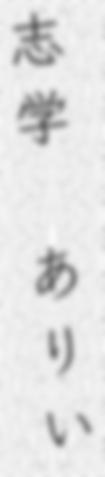

Dự đoán: 志学 ありい 
Sự thật: 志学 ありい


In [16]:
print("\n=== KIỂM THỬ PIPELINE ===")

pipeline = JapaneseOCRRecognitionPipeline(inference_model, idx_to_char)

sample = val_ds[10]
predicted_text = pipeline.process_image(sample["image"], orientation=1)

display(sample["image"])
print("Dự đoán:", predicted_text)
print("Sự thật:", sample["string"])



=== KIỂM THỬ PIPELINE ===
1. ẢNH GỐC:


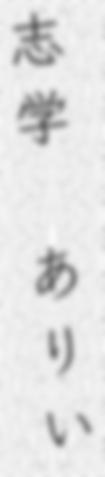


 -> Ảnh dọc, đang thực hiện xoay...

2. ẢNH SAU KHI XỬ LÝ (Ảnh model thực sự thấy):


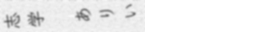


Đang dự đoán...
 -> Dự đoán: 志学 ありい 
 -> Sự thật: 志学 ありい


In [17]:
# ... trong hàm main, sau khi tạo pipeline ...

print("\n=== KIỂM THỬ PIPELINE ===")

pipeline = JapaneseOCRRecognitionPipeline(inference_model, idx_to_char)

# Chọn một mẫu để kiểm tra
sample = val_ds[10] 

# ------------------------------------------------------------------
# PHẦN THÊM VÀO ĐỂ HIỂN THỊ ẢNH ĐÃ XỬ LÝ
# ------------------------------------------------------------------

# Lấy ảnh gốc
original_image = sample["image"]
print("1. ẢNH GỐC:")
display(original_image)

# Bước 1: Giả lập việc xoay ảnh nếu cần
image_to_process = original_image
if sample["orientation"] == 1:
    print("\n -> Ảnh dọc, đang thực hiện xoay...")
    image_to_process = image_to_process.transpose(Image.ROTATE_90)

# Bước 2: Gọi hàm preprocess_image để lấy kết quả cuối cùng (dạng NumPy)
# Đây chính là ảnh mà model sẽ nhận được
final_processed_numpy = preprocess_image(image_to_process, img_height=IMG_HEIGHT, img_width=IMG_WIDTH)

# Bước 3: Chuyển đổi NumPy array ngược lại thành ảnh có thể hiển thị
#   - np.squeeze: Bỏ các chiều có kích thước là 1 (32, 128, 1) -> (32, 128)
#   - * 255: Chuyển giá trị từ khoảng [0, 1] về lại khoảng [0, 255]
#   - .astype('uint8'): Chuyển sang kiểu số nguyên 8-bit mà ảnh yêu cầu
#   - Image.fromarray: Tạo ảnh PIL từ NumPy array
displayable_image = Image.fromarray((np.squeeze(final_processed_numpy) * 255).astype('uint8'))

print("\n2. ẢNH SAU KHI XỬ LÝ (Ảnh model thực sự thấy):")
display(displayable_image)

# ------------------------------------------------------------------
# Phần dự đoán giữ nguyên
# ------------------------------------------------------------------
print("\nĐang dự đoán...")
predicted_text = pipeline.process_image(sample["image"], orientation=sample["orientation"])

print(" -> Dự đoán:", predicted_text)
print(" -> Sự thật:", sample["string"])